# EXERCISE 6 (c)

## AIM:
    1. Test the performance on the model trained on smaller NGZ , on the current environment.
    2. Discuss the generalizability of the model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd './drive/MyDrive/Exercises/Exercise 06'

/content/drive/MyDrive/Exercises/Exercise 06


### Importing required libraries

In [ ]:
!pip install stable-baselines3
!pip install shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.9 MB/s eta 0:00:00


In [ ]:
import gymnasium
import os
import math
import pandas as pd
import numpy as np
import seaborn as sb
from shapely import geometry
import geopandas as gpd
from PIL import Image
from shapely.geometry import LineString, Point, Polygon
import matplotlib.pyplot as plt
from gymnasium import spaces
from PIL import Image
import copy
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

these are additional codes to import data, re-scale, transform and visulaize the sector.
No changes needed here.

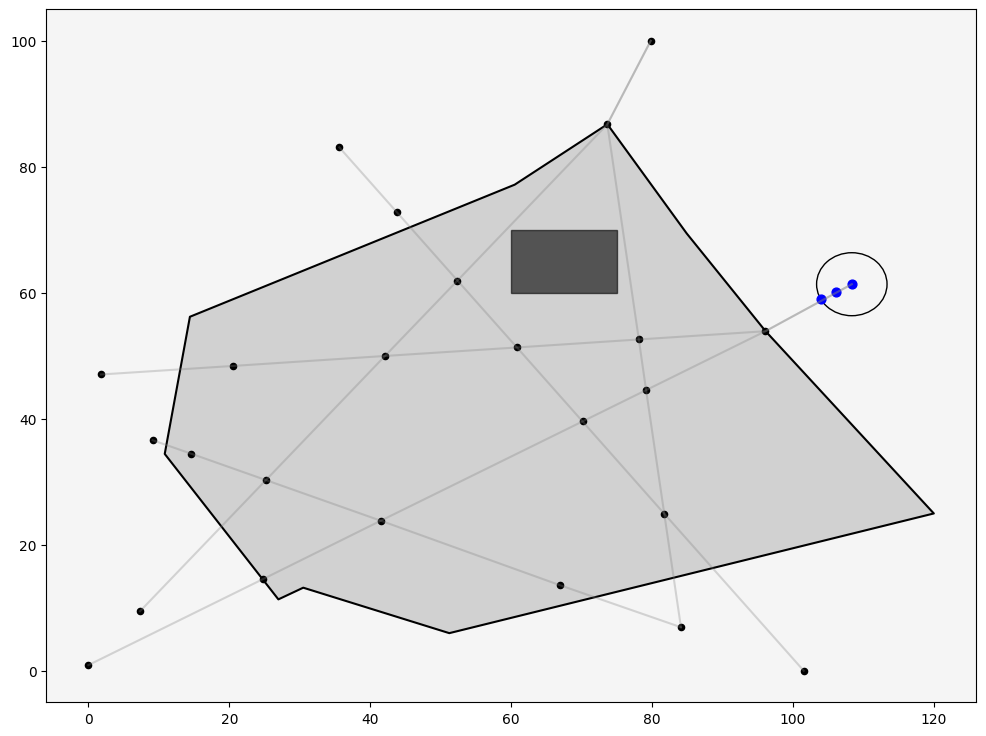

In [ ]:
df = gpd.read_file('test.geojson')
poly = df.geometry[5]
x, y = poly.exterior.coords.xy
xx = np.array(x)
yy = np.array(y)

# concatenating lat lons from two file to see the actual range for transformation
wpfile = pd.read_csv('path_Waypoints22feb.csv')
# print(wpfile.columns)
wps = pd.DataFrame(wpfile[['NAME','LAT', 'LON']])
lon = wps[['LON']].to_numpy()
lat = wps[['LAT']].to_numpy()
lon = lon.ravel()
lat = lat.ravel()
lon_array = np.concatenate((xx, lon))
lat_array = np.concatenate((yy, lat))

def rescaling_x(r_min, r_max,m, t_min = 0, t_max = 120):
    """rescaling given the r_min and r_max (current range) and T_min and t_max of target range, and the measurement m """
    delta_r = r_max - r_min
    delta_t = t_max - t_min
    scaledx = (m - r_min)*(delta_t)/delta_r + t_min
    return scaledx

def rescaling_y(r_min, r_max,m, t_min = 0, t_max = 100):
    """rescaling given the r_min and r_max (current range) and T_min and t_max of target range, and the measurement m """
    delta_r = r_max - r_min
    delta_t = t_max - t_min
    scaledy = (m - r_min)*(delta_t)/delta_r + t_min
    return scaledy


sector_X = []
sector_Y = []
for i in range(len(x)):
    x_ = rescaling_x(min(lon_array), max(lon_array), x[i])
    y_ = rescaling_y(min(lat_array), max(lat_array), y[i])
    sector_X.append(x_)
    sector_Y.append(y_)

waypoints_X = []
waypoints_Y = []
for i in range(len(wps)):
    x_ = rescaling_x(min(lon_array), max(lon_array), wps.iloc[i]['LON'])
    y_ = rescaling_y(min(lat_array), max(lat_array),  wps.iloc[i]['LAT'])
    waypoints_X.append(x_)
    waypoints_Y.append(y_)

pathfile = pd.read_csv('22feb_paths')
pathfile  = pathfile.drop(['ROUTE_NAME','SID', 'STAR', 'Unnamed: 10'], axis = 1).reset_index(drop = True)
pathfile = pathfile.drop([])
pathfile


w = wps['NAME'].to_list()
namedata = pd.DataFrame(data = zip(w, waypoints_X, waypoints_Y), columns = ['name', 'X', 'Y'])
namedata = namedata.round(2)

# path1, path2, path3, path4, path5, path6 = [], [], [], [], [], []
pathlist = []
for i in range(len(pathfile)):
    path = []
    for j in range(len(pathfile.loc[i])):
        for k in range(len(namedata)):
            if pathfile.loc[i][j] == namedata.loc[k]['name']:
                path.append([namedata.loc[k]['X'], namedata.loc[k]['Y']])
    pathlist.append(path)

def plot_traj(item):
    fig, ax = plt.subplots(1,1, figsize = (15,8))
    plt.plot(sector_X, sector_Y, color = 'black')
    x = []
    y = []
    for i in range(len(item)):
        x.append(item[i][0])
        y.append(item[i][1])
    plt.scatter(x, y, linewidth = 0.1)


fig,ax = plt.subplots(figsize = (12,9))
ax.set_facecolor('whitesmoke')

plt.plot(sector_X, sector_Y, color = 'black')
plt.fill(sector_X, sector_Y, 'grey', alpha = 0.3)
plt.scatter(waypoints_X, waypoints_Y, c='black',s =20)
# ngz = Polygon(Point(60,35),Point(60,40), Point(70,40),Point(70,35))

ngz = Polygon([(60,60),(60,70), (75,70),(75,60)])
# plt.plot(*ngz.exterior.xy, color = 'red')
plt.fill(*ngz.exterior.xy, color = 'black', alpha = 0.6)

speed = 2.5
x, y  = pathlist[2][0][0], pathlist[2][0][1]
heading = np.pi +0.5
x_, y_ = x + speed*np.cos(heading), y + speed *np.sin(heading)
x3, y3 = x_ + speed*np.cos(heading), y_ + speed *np.sin(heading)
plt.scatter(x,y, color = 'blue', s = 40)
circle = plt.Circle((x,y),5, fill = False)
ax.add_patch(circle)
plt.scatter(x_, y_, color = 'blue', s = 40)
plt.scatter(x3, y3, color = 'blue', s = 40)

for i in range(len(pathlist)):
    x = []
    y = []
    for j in range(len(pathlist[i])):
        x.append(pathlist[i][j][0])
        y.append(pathlist[i][j][1])
    plt.plot(x, y, color = 'grey', alpha  = 0.3)
    # plt.scatter(Own_positionlist[0], Own_positionlist[1])

    # plt.scatter(92, 62, color = 'green')

def agentposition(waypointlist, speed):
    agentpositionlist = []
    agentpositionlist_final = []
    for i in range(1, len(waypointlist)):
        startpoint_init = waypointlist[i-1]
        agentpositionlist.append(np.array(startpoint_init))
        endpoint = waypointlist[i]
        endpoint_poly = geometry.Point(endpoint[0], endpoint[1])
        buffer = 1.5 # raiuds of circle to check in or out
        circlebuffer = endpoint_poly.buffer(buffer)
        startpoint = waypointlist[i-1]

        for j in range(100): # 100 is a random number here
            totaldist = math.dist(endpoint, startpoint)
            s =  speed
            ratio = speed / totaldist
            p0 = startpoint[0]*(1- ratio) + ratio* endpoint[0]
            p1 = startpoint[1] * (1- ratio) + ratio * endpoint[1]
            position_ = [p0, p1]
            agentpositionlist.append(np.round(position_,2))
            startpoint = position_
            point2_poly = geometry.Point(startpoint)
            if circlebuffer.contains(point2_poly):
                break
    for i in range(1, len(agentpositionlist)):
        p1 = Point(agentpositionlist[i-1][0], agentpositionlist[i-1][1])
        p2 = Point(agentpositionlist[i][0], agentpositionlist[i][1])
        pos1 = [p1.x, p1.y]
        pos2 = [p2.x, p2.y]
        distance = p1.distance(p2)
        if distance < 1:
            pass
        else:
            agentpositionlist_final.append(np.array(pos1))

    return agentpositionlist_final

#pairwise_offsets
def pairwise_offsets(onwlist, intlist):
    """calculate paiwise offsets between onwship and intruder's pathlists."""
    offsetlist = []
    onwindex = 0
    intindex = 0
    for i in range(len(onwlist)):
        for j in range(len(intlist)):
            if onwlist[i][0] == intlist[j][0] and onwlist[i][1] == intlist[j][1]:
                # print(i, j)
                # print(onwlist[i][0], intlist[j][0])
                onwindex = i
                intindex = j
                break
    if onwindex > intindex: # becuse onwship take more steps to reach conflict point, add the offset to intruder
        # print('Yes')
        delta = onwindex - intindex
        # print(delta)
        offsetlist.append(0)
        offsetlist.append(delta)
        # return offsetlist
    else:
        delta = intindex - onwindex
        offsetlist.append(delta)
        offsetlist.append(0)


    # print('ultimate offsetlist', offsetlist)
    return offsetlist

def creating_offsets():
    """extract infor of agents' path, speed, offsets after each random choice. Ownship speed is defined here"""
    # speedlist = [1.0 ,1.1 ,1.15 ,1.2 ,1.25]
    speedlist = [2, 2.1, 2.2, 2.25, 2.3, 2.35, 2.4]
    speedOwn = 2.5
    Ownpath= agentposition(pathlist[2], 2.5)
    speedint1 = np.random.choice(speedlist)
    speedint2 = np.random.choice(speedlist)
    Int1path = agentposition(pathlist[0], speedint1)
    Int2path = agentposition(pathlist[1], speedint2)
    off1 = pairwise_offsets(Ownpath, Int1path)
    off2 = pairwise_offsets(Ownpath, Int2path)
    # print(len(Ownpath), len(Int1path), len(Int2path))

    if off1[0] > off2[0]: # example [10, 4] and [2,1]
        delta1 = off1[0] - off2[0]
        off2[0], off2[1] = off2[0] + delta1, off2[1] + delta1
    elif off1[0] < off2[0]:
        delta2 = off2[0] - off1[0]
        off1[0], off1[1] = off1[0] + delta2, off1[1] + delta2

    offsetlist = [off1[0], off1[1], off2[1]] # added 5 just to create a situation of secondary conflict after maneuver
    # print("offsetlist: ", offsetlist)
    linestringOwn  = LineString(pathlist[2])

    Own_positionlist = copy.deepcopy(Ownpath)
    Int_positionlist1 = copy.deepcopy(Int1path)
    Int_positionlist2 = copy.deepcopy(Int2path)

    return Ownpath, Int1path, Int2path, linestringOwn, speedOwn, speedint1, speedint2, offsetlist, Own_positionlist, Int_positionlist1, Int_positionlist2


### Create the Ownship and Intruder Class

In [ ]:
class Ownship():
    def __init__(self, path, speed, wp_linestring,  offset):
        self.start_time = 0
        self.pathlist = tuple(copy.deepcopy(path))
        self.position  = path[0]
        self.speed = speed
        self.heading = np.pi + 0.5 # fixing the initial heading and path of ownship pathlist[2]. 0.73 is the initial slope
        self.new_path = []
        self.offset = offset
        self.wp_linestring = wp_linestring
        self.int1dist = []
        self.int2dist = []
        self.num_actions = 0

    def step(self, new_heading, n_step):
        # if n_step <= self.offset:
        #     return self.position

        if n_step <= self.offset:
            return self.position

        self.heading = new_heading
        # print('original position', self.position)
        self.position[0] = np.clip((self.position[0] + self.speed*np.cos(new_heading)), 0, 120)
        self.position[1] = np.clip((self.position[1] + self.speed*np.sin(new_heading)), 0, 100)
        # print('ownship position after agent step function', self.position)
        return self.position


class Intruder():
    def __init__(self, path, speed, offset):
        self.pathlist  = tuple(copy.deepcopy(path))
        self.speed = speed
        self.position = path[0]
        self.done = False
        self.offset = offset

    def step(self, n_step):
        if n_step >= len(self.pathlist):
            return self.position

        if n_step <= self.offset:
            return self.position

        self.position[0] = self.pathlist[n_step - self.offset][0]
        self.position[1] = self.pathlist[n_step - self.offset][1]
        return self.position


def heading(point1, point2): #calculations relative to x axis
    delta_y =point2[1] - point1[1]
    delta_x =  point2[0] - point1[0]
    if delta_x == 0:
        delta_x = 0.005

    slope = np.round((delta_y) / (delta_x), 3)

    if point2[1] > point1[1] and point2[0] > point1[0]: #first quadrant
        head =  slope
    elif point2[1] > point1[1] and point2[0] <point1[0]: #second quadrant
        head = 0.5*np.pi + slope
    elif point2[1] < point1[1] and point2[0] < point1[0]: #third quad
        head = np.pi + slope
    elif point2[1] < point1[1] and point2[0] > point1[0]:
        head = 1.5 * np.pi + slope
    elif point2[1] - point1[1] == 0 and point2[0] < point1[0]:
        head = np.pi + slope
    else:
        head = slope


    return head

### Create the Sector 6 environment with two intruders and a with new location of the No Go Zone in the environment
    - The NGZ is created using the Shapely Polygons

In [ ]:
class StructuredEnv(gymnasium.Env):
    SAFE_R = 5

    ALPHA = 0.1 * np.pi
    # ALPHA = (0)
    MAX_STEP = 80
    # high = 0.1 * np.pi
    Ownpath, Int1path, Int2path, linestringOwn, speedOwn, speedint1, speedint2, offsetlist, Own_positionlist,Int_positionlist1, Int_positionlist2 = creating_offsets()
    def __init__(self, Reward_Params= [-1, -1, -1, -1, -1, 1]):
        self.Reward_Params = Reward_Params
        self.agents = [Ownship(copy.deepcopy(self.Ownpath),self.speedOwn, self.linestringOwn, self.offsetlist[0]),
                                            Intruder(copy.deepcopy(self.Int_positionlist1), self.speedint1, self.offsetlist[1]),
                                            Intruder(copy.deepcopy(self.Int_positionlist2), self.speedint2, self.offsetlist[2])]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        n_observations = np.size(self.observation_func())
        n_action = 1
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Box(low = -100, high = 120, shape= (n_observations, ), dtype = np.float64)

    def reset(self, seed = 0):
        self.agents = [Ownship(copy.deepcopy(self.Ownpath),self.speedOwn, self.linestringOwn, self.offsetlist[0]),
                                            Intruder(copy.deepcopy(self.Int_positionlist1), self.speedint1, self.offsetlist[1]),
                                            Intruder(copy.deepcopy(self.Int_positionlist2), self.speedint2, self.offsetlist[2])]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0

        observation = self.observation_func()

        return observation, {}

    def step(self, action):
        self.n_step += 1

        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            speed = self.agents[i].speed
            if i == 0:
                heading = self.agents[i].heading
                if action == 0:
                    angle = -0.056 *np.pi # 10 degree
                if action == 1:
                    angle = -0.111 *np.pi # 20 deg
                if action == 2:
                    angle = -0.167 *np.pi  #30 deg
                if action == 3:
                    angle = -0.222 *np.pi  # 40deg
                if action == 4:
                    angle = 0
                if action == 5:
                    angle = 0.056 *np.pi # 10 degree
                if action == 6:
                    angle = 0.111 *np.pi # 20 deg
                if action == 7:
                    angle = 0.167 *np.pi  #30 deg
                if action == 8:
                    angle = 0.222 *np.pi  # 40deg
                heading = heading+ angle
                self.agents[i].step(heading, self.n_step) # new location for ownship
                self.agents[i].new_path.append(np.array(self.agents[i].position))
            else:
                self.agents[i].step(self.n_step)
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        dis2 = np.linalg.norm(self.agents[0].position - self.agents[2].position)
        self.agents[0].int1dist.append(dis1)
        self.agents[0].int2dist.append(dis2)

        self.done  = self.check_stopping_condition()
        self.reward = self.reward_func(action, self.done)
        observation = self.observation_func()

        info = {}
        self.total_reward += np.round(self.reward, 2) # just for monitoring the model performance.

        return observation, self.reward, self.done, False, info

    def check_stopping_condition(self):
        done = False
        x, y = self.agents[0].position
        current_location = Point(x, y)
        x_thresh = self.agents[0].pathlist[-1][0]
        y_thresh = self.agents[0].pathlist[-1][1]

        # creating a NO GO ZONE
        # ngz = Polygon([(60,18),(60,28), (75,28),(75,18)])
        ngz = Polygon([(60,60),(60,70), (75,70),(75,60)])

        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        dis2 = np.linalg.norm(self.agents[0].position - self.agents[2].position)
        own_ngz_dist = current_location.distance(ngz)
        dist = np.linalg.norm(self.agents[0].position - np.array([x_thresh, y_thresh]))
        if (dist < 2) or (self.n_step >= self.MAX_STEP) or self.agents[0].position[0] <= x_thresh :
            return True

        if (dis1 < self.SAFE_R) or (dis2 < self.SAFE_R) or (own_ngz_dist < (self.SAFE_R/2)):
            return True

        return False


    def reward_func(self, action, done):
        """
        Reward = a1 * Reward_Step (-ve) +
                 a2 * Reward_Deviation (-ve) +
                 a3 * Reward_LOS (-ve) +
                 a4 * Reward_Maneuvering(-ve) +
                 a5 * Reward_Not_Reached (-ve)+
                 a6 * Reward_Reached (+ve)
        """
        a1 = self.Reward_Params[0]
        a2 = self.Reward_Params[1]
        a3 = self.Reward_Params[2]
        a4 = self.Reward_Params[3]
        a5 = self.Reward_Params[4]
        a6 = self.Reward_Params[5]

        Reward_Step = 0.2

        x_thresh = self.agents[0].wp_linestring.coords[-1][0]
        y_thresh = self.agents[0].wp_linestring.coords[-1][1]
        terminal_location = np.array([x_thresh, y_thresh])
        current_location = Point(self.agents[0].position)
        # ngz = Polygon([(60,18),(60,28), (75,28),(75,18)])
        ngz = Polygon([(60,60),(60,70), (75,70),(75,60)])

        own_ngz_dist = current_location.distance(ngz)

        Moving_back_reward = 0
        mergingreward = 0
        CTDreward = 0
        CTD_merge_reward = 0

        CTD_distance  = current_location.distance(self.agents[0].wp_linestring)
        CTDreward = 1 * (CTD_distance/100)

        if self.n_step < 2:
            Moving_back_reward = 0

        else:
            previous_location = self.agents[0].new_path[-2]
            current_location = self.agents[0].position

            prev_distance = np.linalg.norm(terminal_location - previous_location)
            current_distance = np.linalg.norm(terminal_location - current_location)
            if current_distance >= prev_distance:
                Moving_back_reward =  1
            else:
                Moving_back_reward = -0.1 # this will become positive reward since the reward_param is negative for this


        Reward_Deviation = CTDreward + Moving_back_reward


        Reward_Maneuvering = 0
        Reward_Not_Reached = 0
        Reward_Reached =0

        # Distance between two aircraft for Loss-of-Separation constraint
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        dis2 = np.linalg.norm(self.agents[0].position - self.agents[2].position)
        # print("dis from reward function", dis1, dis2, own_ngz_dist)
        Reward_LOS = 0
        if (dis1 < self.SAFE_R) or (dis2 < self.SAFE_R) or (own_ngz_dist < self.SAFE_R/2):
        # if (dis1 < self.SAFE_R*2):
            Reward_LOS = 100

        Reward_num_actions_total = 0
        if done:
            x_thresh = self.agents[0].wp_linestring.coords[-1][0]
            y_thresh = self.agents[0].wp_linestring.coords[-1][1]
            terminal_location = np.array([x_thresh, y_thresh])
            if self.n_step == self.MAX_STEP:
                current_location = self.agents[0].position
                dist = np.linalg.norm(terminal_location - current_location)
                Reward_Not_Reached = 10*(dist/100)
            else:
                Reward_Reached = 100

            Reward_num_actions_total =  -self.agents[0].num_actions


        r_ = a1 * Reward_Step + a2 *Reward_Deviation + a3 * Reward_LOS + a4 * Reward_Maneuvering + \
                    a5 * Reward_Not_Reached + a6 * Reward_Reached +  1*(Reward_num_actions_total)

        # reward = np.float64(r_/100) # appx normalization
        reward = r_
        return reward


    def observation_func(self):
        observation  = []
        # print(self.agents[0].position)
        dist1 = np.linalg.norm(self.agents[0].position - self.agents[1].position) # ownship and intruder1
        dist2 = np.linalg.norm(self.agents[0].position - self.agents[2].position) # ownship and intruder2
        x_thresh = self.agents[0].wp_linestring.coords[-1][0]
        y_thresh = self.agents[0].wp_linestring.coords[-1][1]
        terminal_location = np.array([x_thresh, y_thresh])
        dist3 = np.linalg.norm(self.agents[0].position - terminal_location)

        current_location = Point(self.agents[0].position)
        CTD_distance  = current_location.distance(self.agents[0].wp_linestring)
        # ngz = Polygon([(60,18),(60,28), (75,28),(75,18)])
        ngz = Polygon([(60,60),(60,70), (75,70),(75,60)])

        own_ngz_dist = current_location.distance(ngz)   # dist of ownship from ngz
        # initial distance
        dis1 = np.linalg.norm(self.agents[0].position - self.agents[1].position)
        dis2 = np.linalg.norm(self.agents[0].position - self.agents[2].position)
        int1dist_observation = dis1
        int2dist_observation = dis2
        if self.n_step <= 2:
            int1dist_observation = - dis1
            int2dist_observation = - dis2

        if 2 < self.n_step < len(self.agents[0].pathlist):
            if self.agents[0].int1dist[self.n_step-1] < self.agents[0].int1dist[self.n_step - 2]: #- ve magnitude i.e converging
                int1dist_observation = - self.agents[0].int1dist[self.n_step -1]
                int2dist_observation = -self.agents[0].int2dist[self.n_step -1]
            else: # positive magnitude i.e diverging
                int1dist_observation =  self.agents[0].int1dist[self.n_step - 1]
                int2dist_observation = self.agents[0].int2dist[self.n_step - 1]

        if self.n_step > len(self.agents[0].pathlist):
            int1dist_observation =  self.agents[0].int1dist[-1]
            int2dist_observation = self.agents[0].int2dist[-1]



        observation.append(dist1)
        observation.append(dist2)
        observation.append(dist3)
        observation.append(CTD_distance) # dist of ownship from the original path
        observation.append(own_ngz_dist)
        observation.append(int1dist_observation)
        observation.append(int2dist_observation)

        observation = np.array(observation)
        return observation


    def render(self, show = False, folder = './Images/'):
        fig, ax = plt.subplots(figsize = (15, 11))
        plt.plot(sector_X, sector_Y, color = 'black')
        plt.fill(sector_X, sector_Y, 'grey', alpha = 0.3)
        plt.scatter(waypoints_X, waypoints_Y, c='black',s =20)


        # ngz = Polygon([(60,18),(60,28), (75,28),(75,18)])
        ngz = Polygon([(60,60),(60,70), (75,70),(75,60)])

        plt.fill(*ngz.exterior.xy, color = 'black', alpha = 0.6)

        plt.scatter(self.agents[0].wp_linestring.coords[-1][0], self.agents[0].wp_linestring.coords[-1][1], c='blue',s =150, alpha = 1, marker= '*')
        for i in range(len(self.agents[0].pathlist)):
            plt.plot(self.agents[0].pathlist[i][0], self.agents[0].pathlist[i][1] ,color= 'red')

        for i in range(len(pathlist)):
            x = []
            y = []
            for j in range(len(pathlist[i])):
                x.append(pathlist[i][j][0])
                y.append(pathlist[i][j][1])
            ax.plot(x, y, color = 'grey', alpha  = 0.3)

        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            if i == 0:
                p_own = Point(self.agents[i].position)
                own_ngz_dist = p_own.distance(ngz)
                ax.scatter(x, y, c='blue', s = 60)
            else:
                ax.scatter(x,y, c='red', s = 60)
            ax.set_title("Step {} - Reward {:.4f} - Total Reward {:.4f} - NGZ_dist {:.2f}".format(self.n_step,self.reward,self.total_reward, own_ngz_dist))

        if show:
            plt.show()
        else:
            plt.savefig(folder + "image_{:0>3}.png".format(self.n_step))
            print(folder + "image_{:0>3}.png".format(self.n_step))

        return fig

    def close(self):
        pass



In [ ]:
from stable_baselines3.common.env_checker import check_env
structured_env = StructuredEnv()
check_env(structured_env)

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
structured_env.observation_space

Box(-100.0, 120.0, (7,), float64)

./Images/image_000.png


<bound method StructuredEnv.close of <__main__.StructuredEnv object at 0x7fe049905de0>>

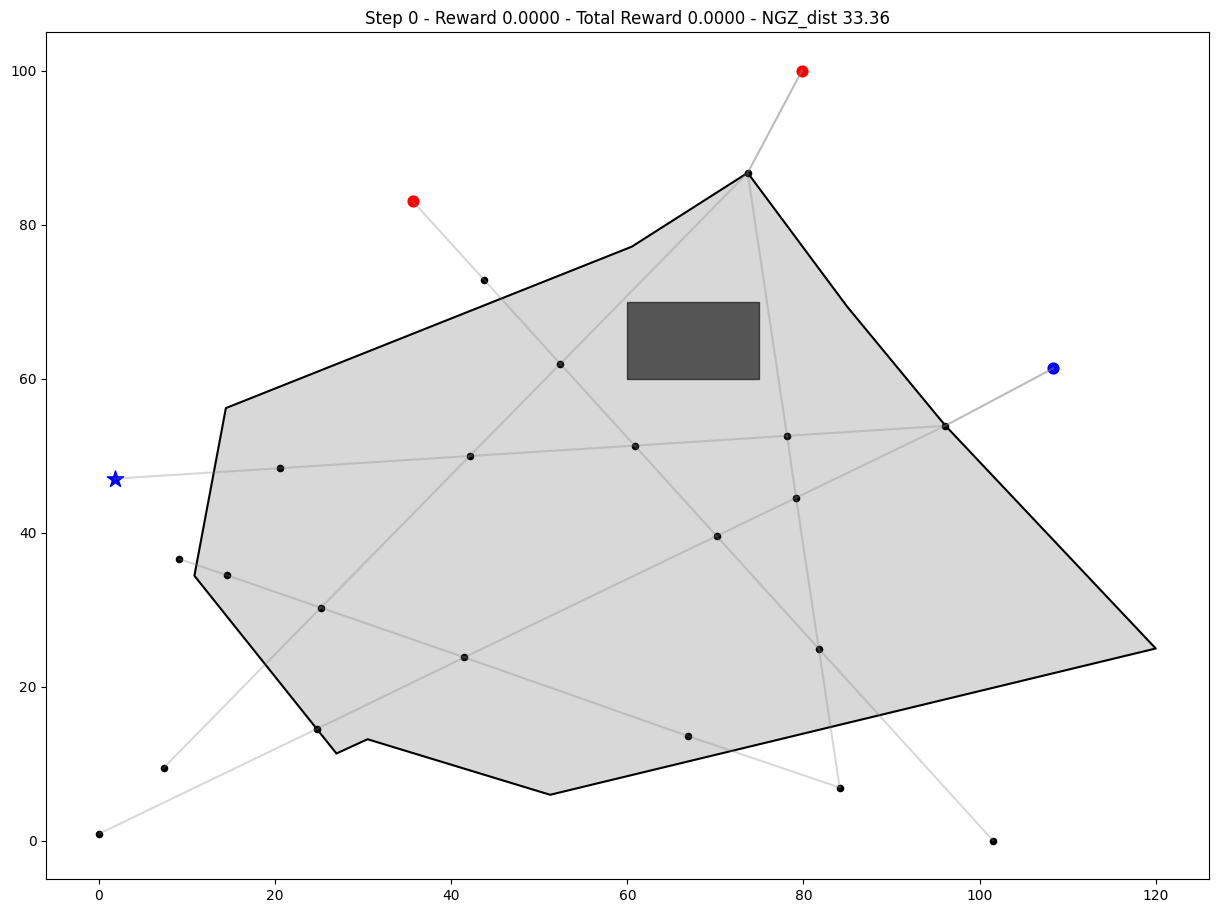

In [ ]:
structured_env.reset()
structured_env.render()
structured_env.close

In [ ]:
structured_env.reset()
structured_env.observation_func()

array([ 75.91354293,  48.03728968, 107.52913001,   0.        ,
        33.36      , -75.91354293, -48.03728968])

In [ ]:
# name = 'structured_env_PPO_NGZ_awway'
# Reward_Params= [-1, -1, -1, -1, -1, 1]

from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

# model = PPO(MlpPolicy, structured_env ,gamma=0.99, tensorboard_log='./Logs/CustomEnv/')
# eval_env = StructuredEnv(Reward_Params)

# eval_callback = EvalCallback(eval_env, best_model_save_path='./log/PPO/',
#                              log_path='./log/PPO/', eval_freq=5000,
#                              deterministic=True, render=False)
# model.learn(total_timesteps= 1000000, tb_log_name=name, callback=eval_callback)
# # model.learn(total_timesteps=1000000, tb_log_name=name)

# # model.save("./Models/CustomEnv/" +name)

# # Evaluate the trained model
# mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)


## Task 1

### Load the model trained on the first environment (EXERCISE 6 a) and test it on the current environment

In [ ]:
import glob
import os
from stable_baselines3 import PPO
name = 'structured_env_PPO_NGZ_new_location'
Reward_Params= [-1, -1, -1, -1, -1, 1]
import time
from PIL import Image
model = PPO.load('./log/PPO/best_model.zip')
# Visualize 1 episode using the trained policy and store the image into selected folder
env = StructuredEnv(Reward_Params)
obs, info = env.reset()
print(obs)
for i in range(80):
    action, state_ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    print(action)

    # Render the game
    c = env.render(False,'./Images/CustomEnv/')
    if done == True:
        print(i)
        break

# Generate the GIF from set of images
fp_in = "./Images/CustomEnv/image_*.png"
fp_out = "./Images/{}.gif".format(name)

imgs = []
for f in sorted(glob.glob(fp_in)):
    imgs.append(Image.open(f))
    os.remove(f)

img = imgs[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=len(imgs)*10, loop=0)

Output hidden; open in https://colab.research.google.com to view.

## Task 2

### Discuss the generalizability of the model and the potential ways to improve it